<a href="https://colab.research.google.com/github/renatoxdias/openset_dogs_cats_final_exam/blob/master/openset_dogs_cats_final_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries


In [0]:
# Installing PyDrive
!pip install PyDrive
import os

import numpy as np

import itertools

from keras import models
from keras import layers
from keras import optimizers
from keras.models import load_model as load_mod
from keras.applications import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
%matplotlib inline


from sklearn.neighbors import KNeighborsClassifier
import numpy as np

from PIL import Image

    100% |████████████████████████████████| 993kB 6.5MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


Using TensorFlow backend.


# Defining Functions

In [0]:
def authent_use():
  # Authenticating user
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  return drive

def donwload_to_colab(filename):
  # Verify list of google drive's IDs
  file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
  for file1 in file_list:
    if file1['title'] == filename:
      ID = file1['id']
  # Searching the dataset in google drive
  fileId = drive.CreateFile({'id': ID})
  print(fileId['title'])
  fileId.GetContentFile(filename)
  
def upload_to_drive(filename, folder_id):
  file = drive.CreateFile({'file':[{u'id': folder_id}]})
  file.SetContentFile(filename)
  file.Upload()
  
def calc_score(prediction, generator, name):
  pred_class = np.argmax(prediction, axis=1)
  label_class = generator.classes
  f1 = f1_score(pred_class, label_class, average='weighted')
  acc_norm = accuracy_score(pred_class, label_class) 
  print('# %s'%name)
  print('F1 score: %f'%f1)
  print('Normalized score: %f\n'%acc_norm)
  
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.grid('off')
  plt.savefig(title)
  upload_to_drive(title+'.png', '123')

# Defining constants

In [0]:
load_model = bool(int(input('Do you want create a model or load an existing one? (0-create / 1-load)')))

Do you want create a model or load an existing one? (0-create / 1-load)1


# Importing Dataset From Google Drive

In [0]:
# Authenticating user
drive = authent_use()

In [0]:
# Download file to google colab from google drive
donwload_to_colab('opensetcatdogs.zip')

opensetcatdogs.zip


In [0]:
%%capture
# Unzipping the dataset
!unzip opensetcatdogs.zip

# Examples of dataset

Image from dog class!


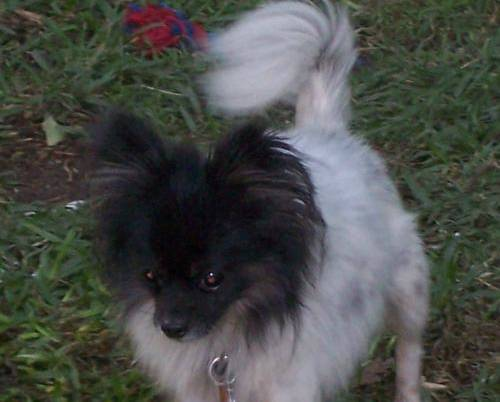


Image from dog cat class!


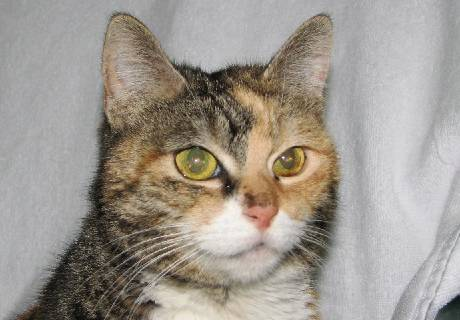


Image from unknown class!


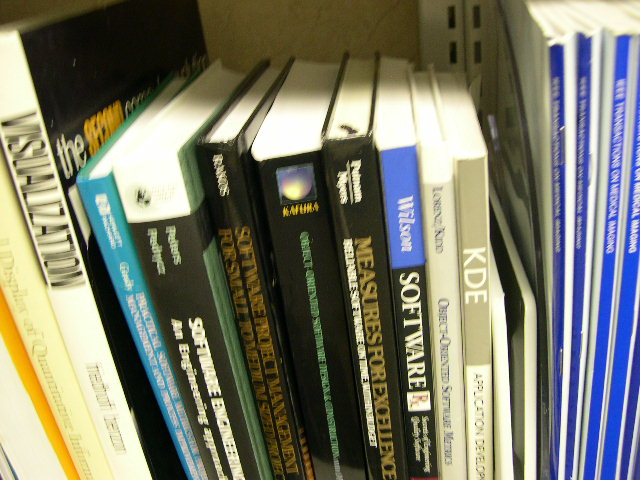

In [0]:
from IPython.display import Image, display

print('Image from dog class!')
display(Image('Data/train/dogs/dog.10012.jpg', width=200, height=200))
print()

print('Image from dog cat class!')
display(Image('Data/train/cats/cat.10006.jpg', width=200, height=200))
print()

print('Image from unknown class!')
display(Image('Data/train/unknown/ukbench06450.jpg', width=200, height=200))
print()

# Defining Generators


In [0]:
train_dir = 'Data/train/'
validation_dir = 'Data/val/'
test_dir = 'Data/test/'

image_size = (256, 256)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
 

train_batchsize = 100
val_batchsize = 100
test_batchsize = 100
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=image_size,
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=test_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 14080 images belonging to 3 classes.
Found 3520 images belonging to 3 classes.
Found 17600 images belonging to 3 classes.


# Importing CNN and fine tuning


In [0]:
if load_model == False:  
  # Freeze all layers
  incept_v2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  for layer in incept_v2.layers[:]:
      layer.trainable = False
      
  ### Create the model 1 ###
  model1 = models.Sequential()
  # Add the vgg convolutional base model
  model1.add(incept_v2)
  # Add new layers
  model1.add(layers.Flatten())
  model1.add(layers.Dense(3, activation='softmax'))
  
  ### Create the model 2 ###
  model2 = models.Sequential()
    # Add the vgg convolutional base model
  model2.add(incept_v2)
  # Add new layers
  model2.add(layers.Flatten())
  model2.add(layers.Dense(128, activation='relu'))
  model2.add(layers.Dropout(0.6))
  model2.add(layers.Dense(3, activation='softmax'))
  
  ### Create the model 3 ###
  model3 = models.Sequential()
  # Add the vgg convolutional base model
  model3.add(incept_v2)
  # Add new layers
  model3.add(layers.Flatten())
  model3.add(layers.Dense(256, activation='relu'))
  model3.add(layers.Dropout(0.6))
  model3.add(layers.Dense(128, activation='relu'))
  model3.add(layers.Dropout(0.6))
  model3.add(layers.Dense(3, activation='softmax'))
  
  ### Create the model 4 ###
  model4 = models.Sequential()
  # Add the vgg convolutional base model
  model4.add(incept_v2)
  # Add new layers
  model4.add(layers.Flatten())
  model4.add(layers.Dense(1024, activation='relu'))
  model4.add(layers.Dropout(0.6))
  model4.add(layers.Dense(256, activation='relu'))
  model4.add(layers.Dropout(0.6))
  model4.add(layers.Dense(128, activation='relu'))
  model4.add(layers.Dropout(0.6))
  model4.add(layers.Dense(3, activation='softmax'))

In [0]:
if load_model == False:
  models = [model1, model2, model3, model4]
  
  for mod in models:
    # Compile the model
    mod.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    # Train the model
    nb_epochs = 5
    history = mod.fit_generator(
          train_generator,
          steps_per_epoch=train_generator.samples/train_generator.batch_size ,
          epochs=nb_epochs,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples/validation_generator.batch_size,
          verbose=1)

# Saving the model

In [0]:
if load_model == False:
  for i in range(4):
    # Save the model
    model_name = 'cnn_model_openset_model'+str(i+1)
    model_ID = 'model'+str(i)
    print(model_name)
    models[i].save(model_name)
    # Upload to drive
    upload_to_drive(model_name, model_ID)

# Loading the model

In [0]:
if load_model == True:
  models = []
  for i in range(4):
    model_name = 'cnn_model_openset_model'+str(i+1)
    # Download file to google colab from google drive
    donwload_to_colab(model_name)
    # Searching the dataset in google drive
    model = load_mod(model_name)
    models.append(model)

1aJawFpqU11RThky37_xN3wqK7PxTYtUj
cnn_model_openset_model1
16fBNiFjnHmZwcLRt15NyiEhE9qtwDQmN
cnn_model_openset_model2
16poKjwIfcTVdwyP9d_FrazVi3NYVvbC8
cnn_model_openset_model3
1qnjCot-0iQxQjXo4_4_c9P6SAHxzTNUB
cnn_model_openset_model4


# Testing the model

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=train_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 14080 images belonging to 3 classes.


In [0]:
pred_models = []

for model in models:

  prediction_train = model.predict_generator(train_generator,steps=train_generator.samples/train_generator.batch_size,verbose=1)
  prediction_validation = model.predict_generator(validation_generator, 
                                           steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
  prediction_test = model.predict_generator(test_generator, 
                                           steps=test_generator.samples/test_generator.batch_size,verbose=1)

  pred_models.append([prediction_train,prediction_validation, prediction_test])

 62/176 [=========>....................] - ETA: 3:41

127/140 [==========================>...] - ETA: 28s

176/176 [==============================] - 344s 2s/step


In [0]:
for i,pm in enumerate(pred_models):
  print("Model %i:"%(i+1))
  print('Results of Prediction!\n')
  calc_score(pm[0], train_generator,'Train')
  calc_score(pm[1], validation_generator, 'Validation')
  calc_score(pm[2], test_generator, 'Test')

Model 1:
Results of Prediction!

# Train
F1 score: 0.806002
Normalized score: 0.808452

# Validation
F1 score: 0.816412
Normalized score: 0.819318

# Test
F1 score: 0.769807
Normalized score: 0.766136

Model 2:
Results of Prediction!

# Train
F1 score: 0.952912
Normalized score: 0.952415

# Validation
F1 score: 0.939257
Normalized score: 0.938068

# Test
F1 score: 0.907706
Normalized score: 0.903125

Model 3:
Results of Prediction!

# Train
F1 score: 0.939437
Normalized score: 0.939986

# Validation
F1 score: 0.925568
Normalized score: 0.925852

# Test
F1 score: 0.890327
Normalized score: 0.889034

Model 4:
Results of Prediction!

# Train
F1 score: 0.941859
Normalized score: 0.942543

# Validation
F1 score: 0.934397
Normalized score: 0.935227

# Test
F1 score: 0.900793
Normalized score: 0.901023



Confusion matrix, without normalization
[[6246    4    0]
 [1423 4820    7]
 [2673    9 2418]]
Confusion matrix, without normalization
[[6236   12    2]
 [ 133 6114    3]
 [1008  547 3545]]
Confusion matrix, without normalization
[[6243    5    2]
 [ 404 5831   15]
 [1437   90 3573]]
Confusion matrix, without normalization
[[6242    5    3]
 [ 484 5746   20]
 [1187   43 3870]]


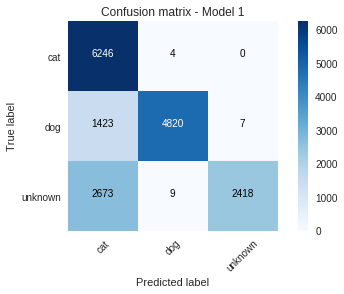

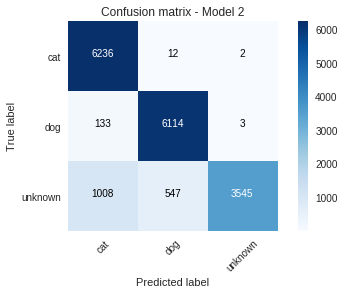

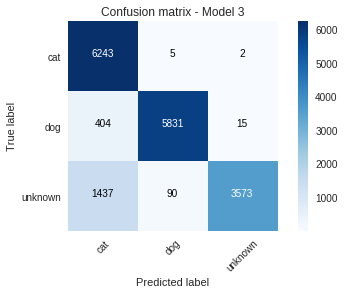

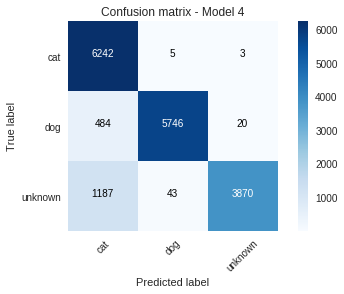

In [0]:
for i,pm in enumerate(pred_models):
  pred_class = np.argmax(pm[2], axis=1)
  label_class = test_generator.classes

  # Compute confusion matrix
  cnf_matrix = confusion_matrix(label_class, pred_class)
  np.set_printoptions(precision=2)

  class_names = ['cat','dog','unknown']

  # Plot non-normalized confusion matrix
  plt.figure()
  plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix - Model %i'%(i+1))

# Reseting notebook

In [0]:
# Reset notebook
!kill -9 -1